In [ ]:
import gdown
import shutil
import os
from pathlib import Path
from fastai.vision.all import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
file_id = '1YHaxS8f6fQ5IMT3JJVeBH40eZSS-UC9h'
zip_file_path = '/content/Images.zip'
extract_folder = '/content/Images'

# Download and extract only if not already done
if not os.path.exists(extract_folder):
    gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', zip_file_path, quiet=False)
    shutil.unpack_archive(zip_file_path, extract_folder)
    print("Files extracted:", os.listdir(extract_folder))
else:
    print("Files already extracted.")

path = Path(extract_folder) / 'Images'


Files already extracted.


In [ ]:
from fastai.vision.all import *
from PIL import Image
import os

# Paths

#path = Path("path/to/original/images")  # Replace with the path to your original images
save_path = Path("cropped/images")  # Replace with the path to save cropped images
save_path.mkdir(parents=True, exist_ok=True)

# Function to crop images into overlapping tiles
def crop_with_overlap(image_path, save_path, tile_size=(512, 512), stride=(256, 256)):
    img = Image.open(image_path)
    width, height = img.size
    label = image_path.parent.name  # Extract label from parent folder
    class_save_path = save_path / label
    class_save_path.mkdir(parents=True, exist_ok=True)

    for i in range(0, width - tile_size[0] + 1, stride[0]):
        for j in range(0, height - tile_size[1] + 1, stride[1]):
            left = i
            upper = j
            right = left + tile_size[0]
            lower = upper + tile_size[1]
            tile = img.crop((left, upper, right, lower))
            tile.save(class_save_path / f"{image_path.stem}_tile_{i}_{j}.jpg")

# Crop images into overlapping tiles
tile_size = (512, 512)
stride = (256, 256)

image_files = get_image_files(path)
for image_file in image_files:
    crop_with_overlap(image_file, save_path, tile_size=tile_size, stride=stride)

# Verify cropped images
sliced_image_files = get_image_files(save_path)
print(f"Total cropped images: {len(sliced_image_files)}")

Total cropped images: 5742


This applies a variety of image augmentation techniques that are built into Fastai. The `aug_transforms` function typically includes:

- **Random Rotation**: Randomly rotates the image by a certain angle.
- **Zoom**: Randomly zooms in or out on the image.
- **Flip**: Randomly flips the image horizontally or vertically.
- **Lighting**: Randomly adjusts the lighting of the image (brightness, contrast, etc.).
- **Affine transformations**: This includes scaling, translation, and shearing to randomly transform the image's perspective.

These transformations are applied to the images during the training process to help the model generalize better by creating slight variations of the images.

The `size=256` argument passed to `aug_transforms` ensures that the final image size after augmentation is 256x256 pixels.


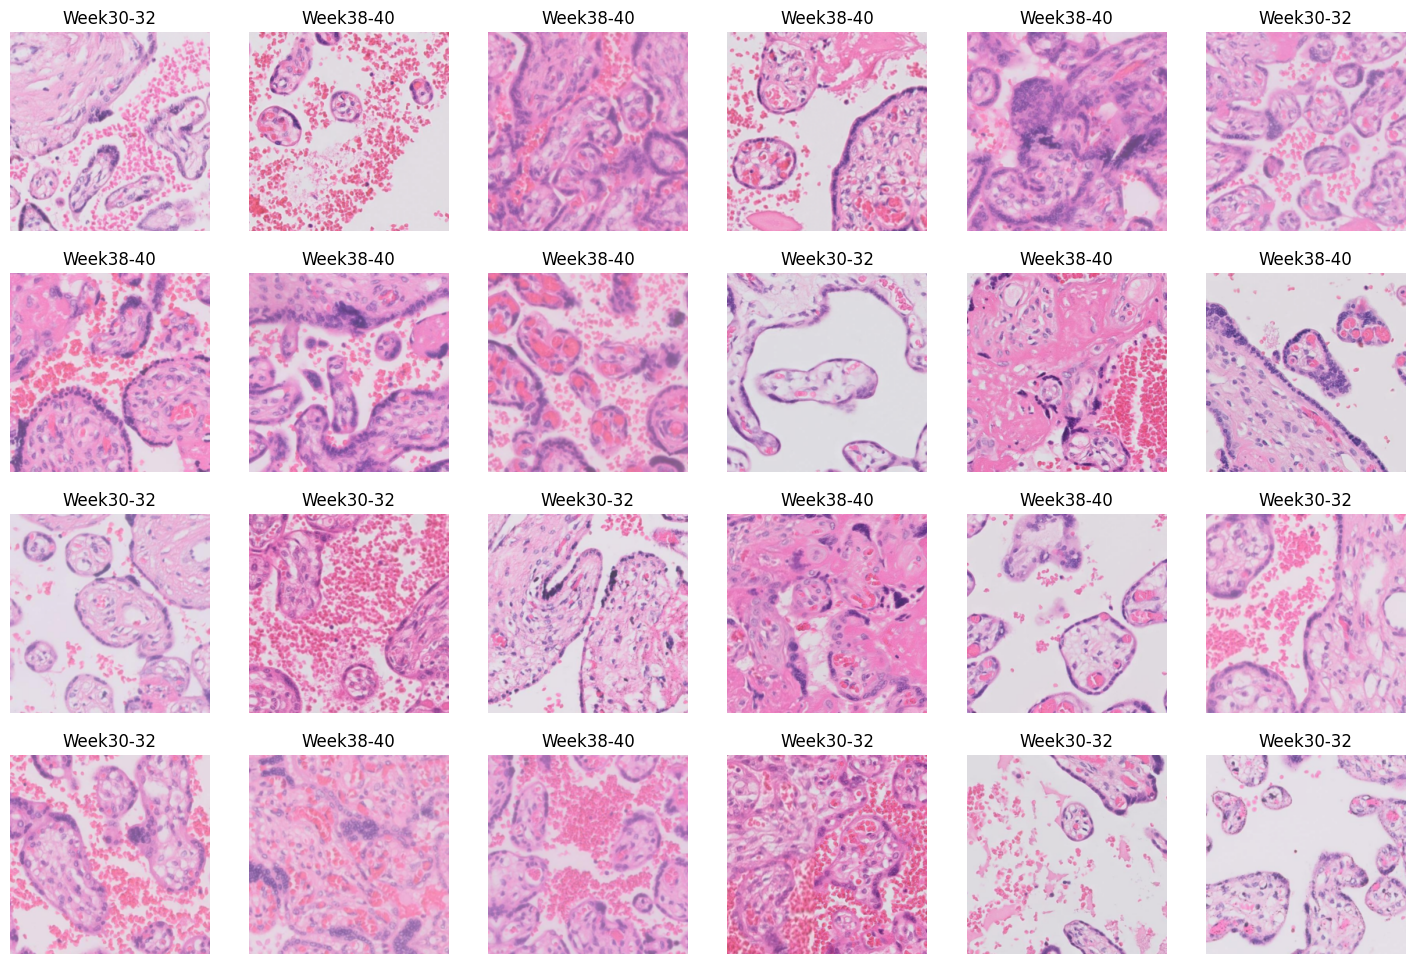

In [ ]:


# Define DataBlock with Augmentations
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms=[
        Rotate(max_deg=20),       # Random rotation
        FlipItem(),              # Random horizontal flip
        RandomResizedCrop(256, min_scale=0.8),  # Random cropping
        Normalize.from_stats(*imagenet_stats)   # Normalization
    ]
).dataloaders(save_path, bs=32)

# Display a batch of augmented images with labels
dls.show_batch(max_n=24)


In [ ]:
# from fastai.vision.all import *
# from torchvision.models import vgg16

# # Load the pre-trained VGG16 model
# vgg_model = vgg16(pretrained=True)

# # Modify the VGG16 model to match the number of classes in your dataset
# num_classes = dls.c  # Number of classes in your dataset
# vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, num_classes)

# # Wrap the model with FastAI's learner
# learn = Learner(dls, vgg_model, metrics=accuracy)

# # Fine-tune the model
# learn.fine_tune(4)

# # Display a batch of predictions (optional)
# learn.show_results()


epoch,train_loss,valid_loss,accuracy,time
0,0.381007,0.588155,0.783101,27:52


epoch,train_loss,valid_loss,accuracy,time
0,0.206833,0.096950,0.962544,27:36


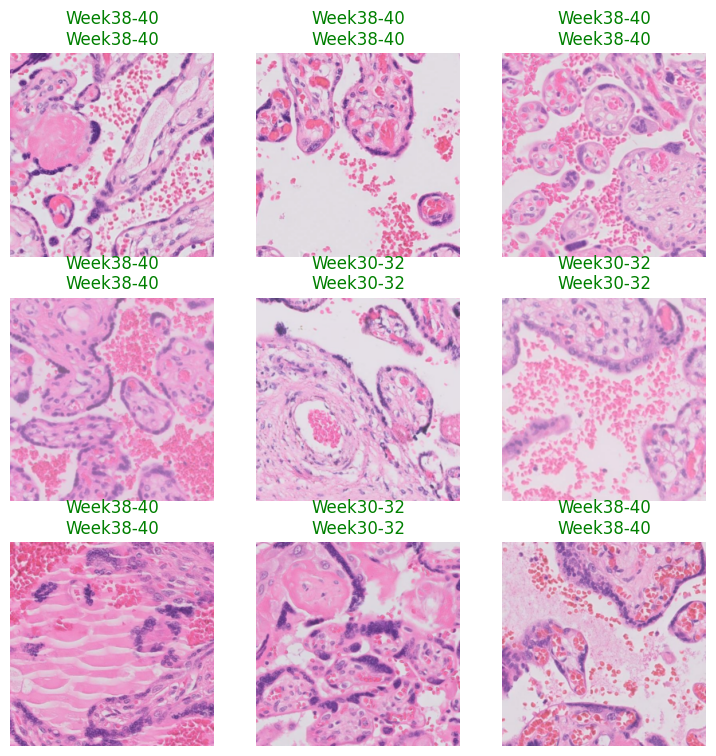

In [ ]:
from fastai.vision.all import *
from torchvision.models import resnet18
import torch.nn as nn

# Load the pre-trained ResNet18 model
resnet_model = resnet18(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_classes = dls.c  # Number of classes in your dataset
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Wrap the model with FastAI's Learner
learn = Learner(dls, resnet_model, metrics=accuracy)

# Fine-tune the model
learn.fine_tune(1)

# Display a batch of predictions (optional)
learn.show_results()

In [ ]:
#learn.save('placenta_classification_base_model')
learn.dls = dls
learn.export('placenta_classification_export.pkl')
learn.save('placenta_classification_export')

Path('models/placenta_classification_export.pth')

In [ ]:


from fastai.vision.all import load_learner

# Correctly load the entire learner with the saved model weights
placenta_resnet18 = load_learner('placenta_classification_export.pkl')


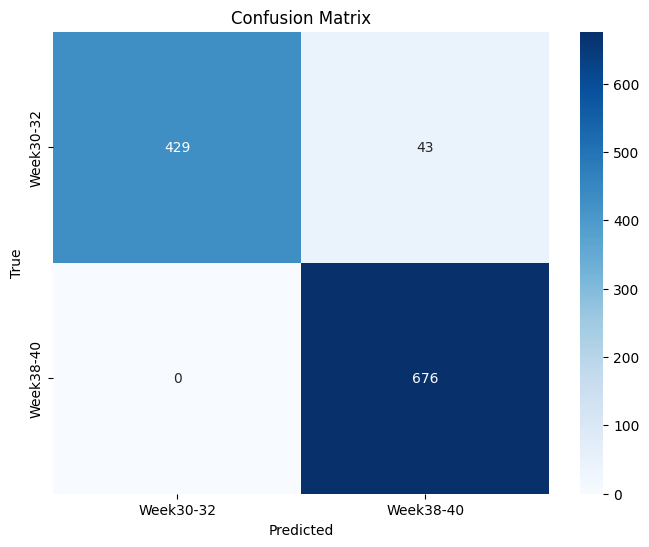

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

probs, y_true = learn.get_preds()
# Get predictions (best threshold) and convert to labels
preds = probs.argmax(dim=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=learn.dls.vocab, yticklabels=learn.dls.vocab)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


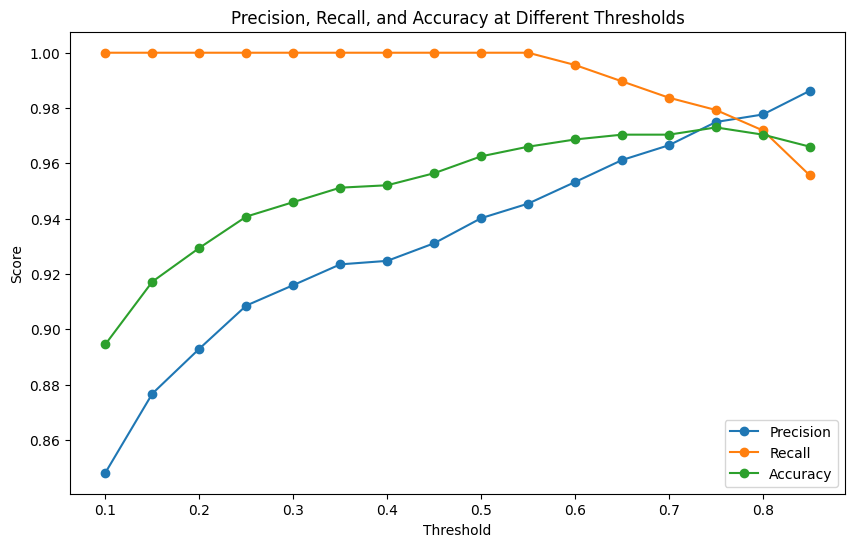

Optimal Threshold for Accuracy: 0.75
Accuracy at Optimal Threshold: 0.97
Precision at Optimal Accuracy Threshold: 0.97
Recall at Optimal Accuracy Threshold: 0.98


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
from fastai.vision.all import *

# Assuming your model has already been loaded and data is available

# Get the probabilities and true labels
probs, y_true = learn.get_preds()

# Set up an array of threshold values to test
thresholds = np.arange(0.1, 0.9, 0.05)
precision_scores = []
recall_scores = []
accuracy_scores = []

# Loop through thresholds to calculate precision, recall, and accuracy
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred_thresh = (probs[:, 1] > threshold).int()  # Assuming class 1 is positive

    # Calculate precision, recall, and accuracy
    precision_scores.append(precision_score(y_true, y_pred_thresh))
    recall_scores.append(recall_score(y_true, y_pred_thresh))
    accuracy_scores.append(accuracy_score(y_true, y_pred_thresh))

# Plot precision, recall, and accuracy scores against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label="Precision", marker='o')
plt.plot(thresholds, recall_scores, label="Recall", marker='o')
plt.plot(thresholds, accuracy_scores, label="Accuracy", marker='o')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and Accuracy at Different Thresholds")
plt.legend()
plt.show()

# Find the optimal threshold for accuracy
optimal_accuracy_index = np.argmax(accuracy_scores)
optimal_accuracy_threshold = thresholds[optimal_accuracy_index]

print(f"Optimal Threshold for Accuracy: {optimal_accuracy_threshold:.2f}")
print(f"Accuracy at Optimal Threshold: {accuracy_scores[optimal_accuracy_index]:.2f}")
print(f"Precision at Optimal Accuracy Threshold: {precision_scores[optimal_accuracy_index]:.2f}")
print(f"Recall at Optimal Accuracy Threshold: {recall_scores[optimal_accuracy_index]:.2f}")

# Generate final predictions using the optimal accuracy threshold
y_pred_optimal_accuracy = (probs[:, 1] > optimal_accuracy_threshold).int()



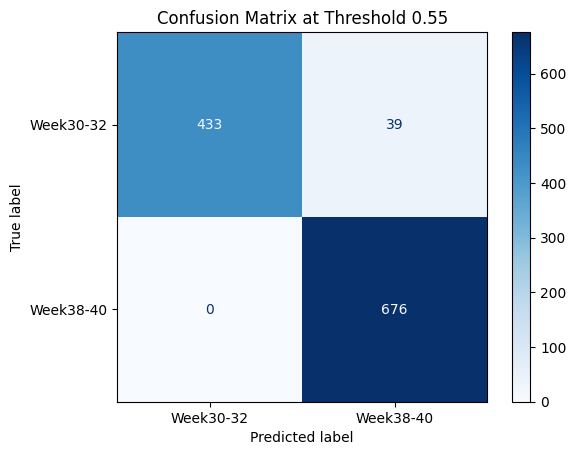

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from the model
probs, y_true = learn.get_preds()

# Set a custom threshold of 0.11
threshold = 0.75
y_pred_thresh = (probs[:, 1] > threshold).int()  # Assuming class 1 is the positive class

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_thresh)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=learn.dls.vocab)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix at Threshold {threshold:.2f}")
plt.show()


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score
from fastai.vision.all import *

# Assuming your model has already been loaded and data is available

# Get the probabilities and true labels
probs, y_true = learn.get_preds()
y_true = y_true.numpy()  # Convert to NumPy array for easy handling
probs = probs.numpy()    # Convert to NumPy array

# Set the optimal threshold (change this if you haven't computed it)
optimal_threshold = 0.5  # Replace with your computed optimal threshold

# Calculate binary predictions based on the optimal threshold
y_pred_optimal = (probs[:, 1] > optimal_threshold).astype(int)

# Create a DataFrame to show probabilities, predicted labels, and true labels
results_df = pd.DataFrame({
    "Prob_Class_0": probs[:, 0],
#    "Prob_Class_1": probs[:, 1],
    "Prediction": y_pred_optimal,
    "True_Label": y_true
})



# If you want to visualize the performance metrics based on this threshold
precision = precision_score(y_true, y_pred_optimal)
recall = recall_score(y_true, y_pred_optimal)

print(f"Precision at Optimal Threshold ({optimal_threshold}): {precision:.2f}")
print(f"Recall at Optimal Threshold ({optimal_threshold}): {recall:.2f}")

# Display the DataFrame to inspect the results
print("Sample of Results DataFrame:")
results_df


Precision at Optimal Threshold (0.5): 0.94
Recall at Optimal Threshold (0.5): 1.00
Sample of Results DataFrame:


,Prob_Class_0,Prediction,True_Label
0,0.000507,1,1
1,0.989977,0,0
2,0.860236,0,0
3,0.034434,1,1
4,0.995304,0,0
...,...,...,...
1143,0.182418,1,0
1144,0.015229,1,1
1145,0.724888,0,0
1146,0.963674,0,0


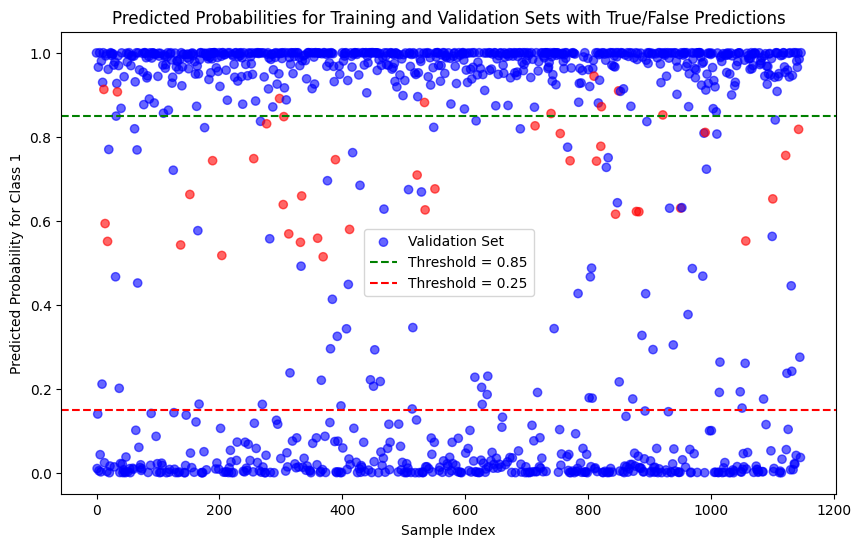

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities for training and validation sets
#train_probs, train_y_true = learn.get_preds(ds_idx=0)  # Training set
valid_probs, valid_y_true = learn.get_preds(ds_idx=1)  # Validation set

# Select the probabilities for the positive class (assuming index 1 is positive)
#train_probs_class1 = train_probs[:, 1].numpy()
valid_probs_class1 = valid_probs[:, 1].numpy()

# Make predictions based on a threshold (e.g., 0.55)
#train_preds = (train_probs_class1 > 0.55).astype(int)
valid_preds= (valid_probs_class1 > 0.5).astype(int)
#valid_preds_dwn = (valid_probs_class1 < 0.25).astype(int)
# Identify the true vs false predictions (correct vs incorrect)
#train_correct = (train_preds == train_y_true.numpy())
valid_correct = (valid_preds == valid_y_true.numpy())

# Scatter plot of probabilities for training and validation sets
plt.figure(figsize=(10, 6))

# Plot training set: Blue for correct, Red for incorrect
#plt.scatter(np.arange(len(train_probs_class1)), train_probs_class1,
#            color=np.where(train_correct, 'blue', 'red'), alpha=0.6, label='Training Set')

# Plot validation set: Blue for correct, Red for incorrect
plt.scatter(np.arange(len(valid_probs_class1)),
            valid_probs_class1,
            color=np.where(valid_correct, 'blue', 'red'), alpha=0.6, label='Validation Set')

# Add threshold line
plt.axhline(y=0.85, color='green', linestyle='--', label='Threshold = 0.85')
plt.axhline(y=0.15, color='red', linestyle='--', label='Threshold = 0.15')
# Add labels and title
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability for Class 1")
plt.title("Predicted Probabilities for Training and Validation Sets with True/False Predictions")
plt.legend()

# Show the plot
plt.show()

